In [1]:
%matplotlib inline
from nansat import *
from netCDF4 import Dataset
from IPython.display import Image

In [2]:
## EXAMPLE PYTHON COMMANDS FOR DOWNLOAD
#wget --user ******* --password ******* ftp://mftp.cmems.met.no/Core/ARCTIC_ANALYSIS_FORECAST_PHYS_002_001_a/dataset-topaz4-arc-myoceanv2-be/20170612_dm-metno-MODEL-topaz4-ARC-b20170612-fv02.0.nc
#wget --user ******* --password ******* ftp://mftp.cmems.met.no/Core/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/METNO-GLO-SEAICE_DRIFT-NORTH-L4-NRT-OBS/2017/06/ice_drift_nh_polstere-625_multi-oi_201706111200-201706131200.nc

In [3]:
### Load data from ARC-MFC file using netCDF4
ds = Dataset('/vagrant/shared/test_data/cmems/20170612_dm-metno-MODEL-topaz4-ARC-b20170612-fv02.0.nc')
uice = ds.variables['uice'][0,::-1,:]
vice = ds.variables['vice'][0,::-1,:]
x = ds.variables['x'][:]*100000.
y = ds.variables['y'][:]*100000.
xmin, xmax, dx = x.min(), x.max(), np.diff(x).mean()
ymin, ymax, dy = y.min(), y.max(), np.diff(y).mean()

In [4]:
# create Nansat object with correct georeference
srs = '+proj=stere +lat_0=90 +lat_ts=90 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +no_defs'
dom = Domain(srs, '-te %d %d %d %d -tr %d %d' % (xmin, ymin, xmax+dx, ymax+dy, dx, dy))
n_arc = Nansat(domain=dom)
n_arc.add_bands([uice, vice])

In [5]:
# Load SIW-TAC data using Nansat
n_siw = Nansat('/vagrant/shared/test_data/cmems/ice_drift_nh_polstere-625_multi-oi_201706111200-201706131200.nc',
                mapperName='generic')
n_siw.vrt.remove_geolocationArray()

In [6]:
# Collocate datasets on pre-defined region of interest
dst_dom = Domain(srs, '-te -3000000 -3000000 3000000 3000000 -tr 12500 12500.0')
n_arc.reproject(dst_dom)
n_siw.reproject(dst_dom)

In [7]:
# get ice drift in m/s
u_arc = n_arc[1]
v_arc = n_arc[2]
u_arc[u_arc < -1000] = np.nan
v_arc[v_arc < -1000] = np.nan

u_siw = n_siw['dX'] * 1000. / 48 / 3600
v_siw = n_siw['dY'] * 1000. / 48 / 3600

<IPython.core.display.Javascript object>


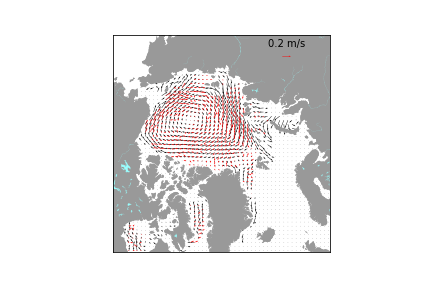

In [80]:
dpi = 300
quivectors=50
scale = 5
width = 0.002

nmap = Nansatmap(dst_dom, resolution='l')
nmap.quiver(u_arc, v_arc, quivectors=quivectors, scale=scale, width=width)
nmap.quiver(u_siw, v_siw, quivectors=quivectors, scale=scale, width=width,
            color='r', X=0.8, Y=0.9, U=0.2, label='0.2 m/s')
nmap.draw_continents()
nmap.save('arc_mfc_vs_siw_tac_sid.png', dpi=dpi)
#$plt.close()


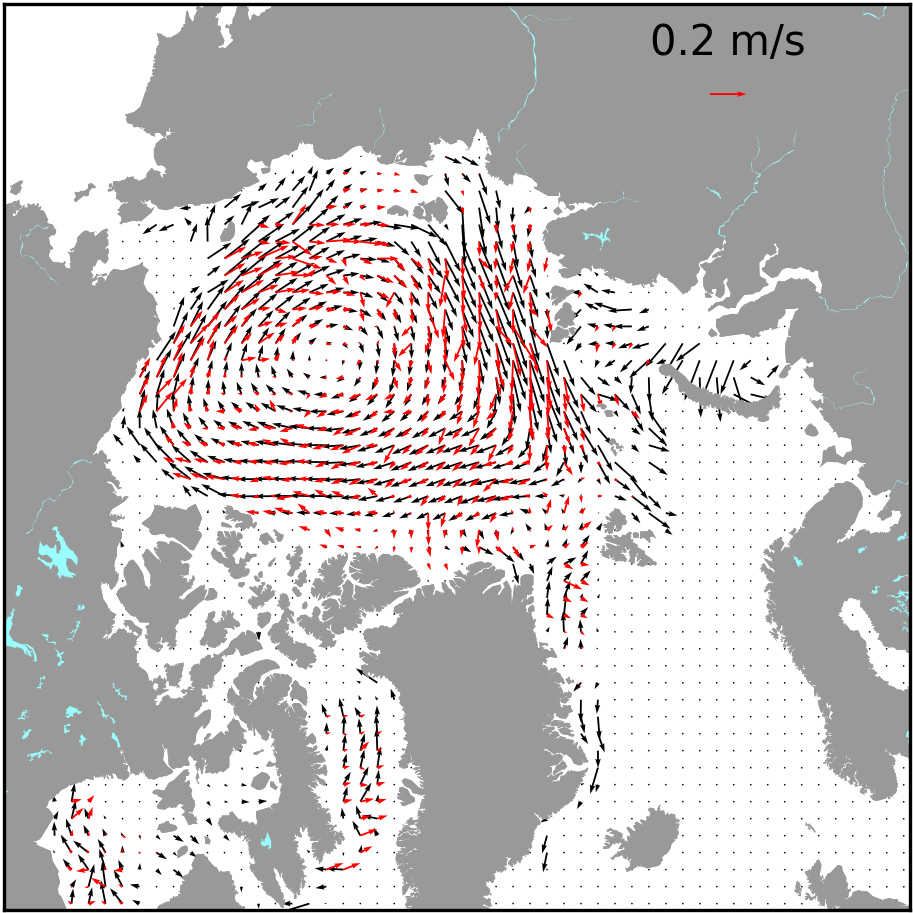

In [81]:
Image('arc_mfc_vs_siw_tac_sid.png')